In [2]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_quantum as tfq
from tensorflow import keras

2022-04-19 11:28:07.121205: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-19 11:28:07.121426: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-04-19 11:28:50.052794: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-19 11:28:50.079419: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-19 11:28:50.089242: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-M1456IP): /proc/driver/nvidia/version does not exist
2022-04-19 11:28:50.404860: I tensorflow/core/platform/cpu_fe

# Task 1 Quantum Computing Part

## 1. Implement a simple quantum operation with Cirq

a) With 5 qubits

b) Apply Hadamard operation on every qubit

c) Apply CNOT operation on (0, 1), (1,2), (2,3), (3,4)

d) SWAP (0, 4)

e) Rotate X with pi/2 on any qubit

f) Plot the circuit 

In [3]:
circuit = cirq.Circuit()
qubits = cirq.LineQubit.range(5) 

circuit.append([cirq.H(qubit) for qubit in qubits])
circuit.append([cirq.CNOT(qubits[i],qubits[i+1]) for i in range(len(qubits) - 1)])
circuit.append([cirq.SWAP(qubits[0], qubits[4])])
circuit.append([cirq.rx(np.pi)(qubit) for qubit in qubits])

print(circuit)

                                  ┌──────┐
0: ───H───@────────────────────────×─────────Rx(π)───
          │                        │
1: ───H───X───@───Rx(π)────────────┼─────────────────
              │                    │
2: ───H───────X───@───────Rx(π)────┼─────────────────
                  │                │
3: ───H───────────X───────@────────┼Rx(π)────────────
                          │        │
4: ───H───────────────────X────────×─────────Rx(π)───
                                  └──────┘


## 2. Create a circuit that is a series of small cirq.Rx rotations and plot the probability of measuring the state in the |0⟩ state. 

In [145]:
circuit2 = cirq.Circuit()
qubit = cirq.NamedQubit("q0")

circuit2.append([cirq.rx(np.pi/8)(qubit) for i in range(6)])
circuit2.append([cirq.measure(qubit, key='q0')])

print(circuit2)

q0: ───Rx(0.125π)───Rx(0.125π)───Rx(0.125π)───Rx(0.125π)───Rx(0.125π)───Rx(0.125π)───M───


Counter({1: 82, 0: 18})


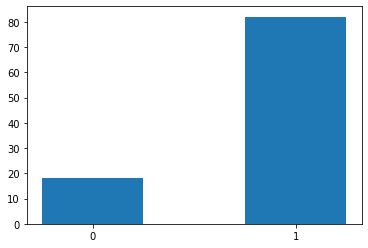

In [169]:
simulator = cirq.Simulator()
result = simulator.run(circuit2,repetitions=100)

print(result.histogram(key='q0'))

fig,ax = plt.subplots()
plt.xticks([0,1])
a=ax.hist(result.records['q0'][:,0,0], bins=[-0.25,0.25,0.75,1.25])

# Task II: Quantum Generative Adversarial Network (QGAN) Part 

You will explore how best to apply a quantum generative adversarial network (QGAN) to solve a High Energy Data analysis issue, more specifically, separating the signal events from the background events. You should use the Google Cirq and Tensorflow Quantum (TFQ) libraries for this task.

A set of input samples (simulated with Delphes) is provided in NumPy NPZ format [Download Input]. In the input file, there are only 100 samples for training and 100 samples for testing so it won’t take much computing resources to accomplish this task. The signal events are labeled with 1 while the background events are labeled with 0.

Be sure to show that you understand how to fine tune your machine learning model to improve the performance. The performance can be evaluated with classification accuracy or Area Under ROC Curve (AUC). 

1. How to represent 5-dim classical vvecto as input to QGAN?
2. Generator/Discriminator - what are input & output?
3. How to train for classification?

In [54]:
def data_gen(data_arr):
    def batch_gen():
        data0 = np.hstack([data_arr['0'][np.random.randint(0, high=50, size=5)],np.zeros((5,1))])
        data1 = np.hstack([data_arr['1'][np.random.randint(0, high=50, size=5)],np.ones((5,1))])
        data_batch = np.vstack([data0, data1])
        np.random.shuffle(data_batch)
        yield data_batch
    return batch_gen()

In [ ]:
def generator(w, **kwargs):
    qml.Hadamard(wires=0)
    qml.RX(w[0], wires=0)
    qml.RX(w[1], wires=1)
    qml.RY(w[2], wires=0)
    qml.RY(w[3], wires=1)
    qml.RZ(w[4], wires=0)
    qml.RZ(w[5], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RX(w[6], wires=0)
    qml.RY(w[7], wires=0)
    qml.RZ(w[8], wires=0)


def discriminator(w):
    qml.Hadamard(wires=0)
    qml.RX(w[0], wires=0)
    qml.RX(w[1], wires=2)
    qml.RY(w[2], wires=0)
    qml.RY(w[3], wires=2)
    qml.RZ(w[4], wires=0)
    qml.RZ(w[5], wires=2)
    qml.CNOT(wires=[0, 2])
    qml.RX(w[6], wires=2)
    qml.RY(w[7], wires=2)
    qml.RZ(w[8], wires=2)
    
circuit = cirq.Circuit()
qubits = cirq.LineQubit.range(10) 

In [57]:
with np.load('QIS_EXAM_200Events.npz',allow_pickle=True) as data:
    train = data['training_input'].item()
    test = data['test_input'].item()
    # print(np.hstack([train['0'][np.random.randint(0, high=50, size=5)],np.zeros((5,1))]))
    
    train_gen = data_gen(train)


[[-0.99925345 -0.99949586  0.07753685 -0.84218034 -0.5149399   0.        ]
 [-0.99865334 -0.99912034  0.07716685 -0.77627523 -0.53754642  0.        ]
 [ 0.34950661  0.58567909  0.91615208 -0.55392065 -0.71591931  0.        ]
 [-0.42585346  0.86764478 -0.9275629  -0.32038269 -0.50555058  1.        ]
 [ 0.88125135 -0.95437964 -0.66664384 -0.78187561 -0.64345757  1.        ]
 [ 0.90560361 -0.9344575  -0.65804998 -0.7947352  -0.58626245  1.        ]
 [ 0.90999432 -0.94429141 -0.6746157  -0.80518637 -0.53296538  1.        ]
 [-0.43030625  0.86671232 -0.92539398 -0.82285501 -0.16938372  1.        ]
 [-0.99916459 -0.99946953  0.07745698 -0.82671955 -0.58793255  0.        ]
 [-0.99889821 -0.99925173  0.07726642 -0.78825187 -0.58779546  0.        ]]


In [17]:
np.vstack([np.random.rand(3,5),np.random.rand(3,5)]).shape

(6, 5)

In [1]:
np.random.randint(0, high=100, size=5)

NameError: name 'np' is not defined

# Task III:

The electron-photon dataset (which can be found here) contains 100 samples for training and another 100 for testing, laid out as follows:

● data["x_train"]: Training dataset of 100 32x32 images containing the particles' energy (100, 32, 32)

● data["y_train"]:" Training labels, 0 = "photon", 1 = "electron" (100,)

● data["x_test"]: Test dataset of 100 32x32 images containing the particles' energy (100, 32, 32)

● data["y_test"]:" Test labels, 0 = "photon", 1 = "electron" (100,)

The dataset labels are labelled 0 for photons and 1 for electrons.

Your task is to

Part a) implement a quantum variational autoencoder in TF Quantum and show its performance

Part b) implement a quantum neural network of any architecture (except convolutional) in Tensorflow Quantum

Part c) implement a QCNN model in TF Quantum

Both types of QNNs should use this dataset’s input and perform binary classification. Please feel free to experiment with different ways of encoding the classical data inputs into the qubits.

Specifically, show that the models fits the dataset and that your training loss decreases over time. (Given the small dataset size, we will not be focusing on the accuracy of your model).


------------------
## Part a) implement a quantum variational autoencoder in TF Quantum and show its performance

['x_train' 'y_train' 'x_test' 'y_test']
[1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0.
 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1.
 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0.
 1. 1. 0. 1.]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 3.25021334e-03
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 8.80289183e-04 5.27916942e-04
  3.21917702e-03 4.93235281e-03 4.19889996e-03 2.89295241e-03
  3.19245714e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.04924760e-04 2.62002111e-03
  2.74827518e-03 3.34637389e-02 7.61364251e-02 1.11197578e-02
  1.98657392e-03 1.43042766e-03]
 [0.00000000e+00 0.0000000

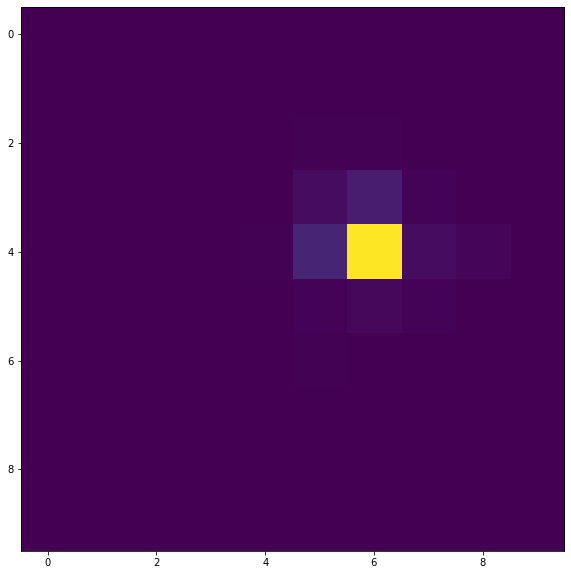

In [43]:
with np.printoptions(threshold=np.inf):
    with np.load('electron-photon.npz',allow_pickle=True) as data:
        print(np.array(data))
        X_train = data['x_train']
        X_test = data['x_test']
        Y_train = data['y_train']
        Y_test = data['y_test']

        # print(X_train[0])
        plt.figure(figsize = (10,10))
        print(Y_train)
        print(X_train[10][12:22,10:20]/np.max(X_train[10][12:22,10:20]))
        plt.imshow(X_train[10][12:22,10:20]/np.max(X_train[10][12:22,10:20]))

# Task IV: Classical Graph Neural Network (GNN)

For Task IV, you will use ParticleNet’s data for Quark/Gluon jet classification available here with its corresponding description.


* Choose 2 Graph-based architectures of your choice to classify jets as being quarks or gluons. 
  * Provide a description on what considerations you have taken to project this point-cloud dataset to a set of interconnected nodes and edges.
  
* Discuss the resulting performance of the 2 chosen architectures.

## Data

There are two arrays in each file:

- X: (100000,M,4), exactly 50k quark and 50k gluon jets, randomly sorted, where M is the max multiplicity of the jets in that file (other jets have been padded with zero-particles), and the features of each particle are its **pt, rapidity, azimuthal angle, and pdgid**.
- y: (100000,), an array of labels for the jets where gluon is 0 and quark is 1.



In [70]:
with np.load('QG_jets.npz',allow_pickle=True) as data:
    print(np.array(data))
    # print(np.array(data['X']))
    X = data['X']
    Y = data['y']

['X' 'y']


In [127]:
np.where(Y==0)[0][:5]

array([ 5, 11, 13, 16, 17])

In [128]:
Y[np.where(Y==0)[0][:5]]

array([0., 0., 0., 0., 0.])

In [117]:
Y[0:6:5]

array([1., 0.])

In [131]:
X[np.where(Y==0)[0][:5],:,-1]

array([[  321.,    22.,    22.,    22.,    22.,    22.,  -211.,   211.,
           22.,    22.,  -211.,    22.,   211.,    22.,    22.,   211.,
         -211.,   130.,   211.,   211.,    22.,    22.,    22.,    22.,
           22.,    22.,    22.,   211.,    22.,   130.,  -211.,  -211.,
         -321.,   321.,    22.,  -211.,  -211.,  -211.,   211.,  -321.,
          321.,    22.,    22.,    22.,  -321.,    22.,   321.,    22.,
           22.,   211.,    22.,   211.,    22.,  -211.,  -211.,    22.,
           22.,    22.,  -211.,  -211.,   211.,   211.,   211.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0., 

In [137]:
pid= X[:,:,-1]

In [143]:
pid_set = set(pid[0])
pid_set

{-321.0, -211.0, 0.0, 22.0, 211.0, 321.0}

In [144]:
pid[0]

array([  22.,   22., -211., -321., -211.,   22.,   22.,  211.,  321.,
       -211.,   22.,   22.,   22.,   22.,   22.,   22.,   22.,   22.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,

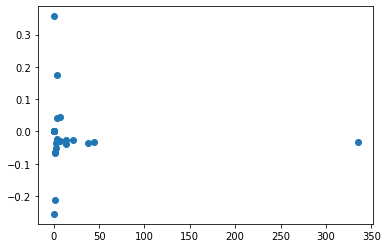

In [146]:
plt.scatter(X[0,:,0],X[0,:,1])

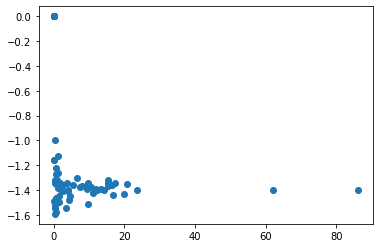

In [154]:
plt.scatter(X[2,:,0],X[2,:,1])

# Task V: Open Task Part

Please comment on quantum computing or quantum machine learning. You can also comment on one quantum algorithm or one quantum software you are familiar with. You can also suggest methods you think are good and you would like to work. Please use your own understanding. Comments copied from the internet will not be considered.

My interest in qunatum machine leaning stems from an intuiotion that when dealing with data sampled from a distribution governed by qunatum physics, a quantum algorith may be more addapt than a classical one. That is, a QNN might be able to learn qunatum correlations (i.e. entanglement) better than a classical ANN. As a person who comes from a condesned matter background, that approach is even more sensible to me, since the lvel of control of experimental systems is quite high compared to that of high-energy partcile accelerators. It implies that a QML algorithm can work directly with the system's quantum state, and so if QML offers a real quantum advantage we wll eventually fully exploit it. In a high-energy context, if I'm not mistaken, sensores provide access only to classical information. However, relying on classical data limits the insights we have into the underlying physics. Thus the task is to reconstruct the quantum distribution from classical information. Given the great success of clasical methods, it is interesting to understand whether quantum approach will provide and advantage (I admint to not being familiar with the literature). In partiular, it might be possible that the classical methods guided us to the tasks they are most suitable for. Developing mature QML techniques can thus expend our vocabulary, and direct us towards asking different questions and constructing instruments that are more addapt to deal with such questions. 

For example, for an Auto-Encoder to be able to reconstruct a state, it must encode some importnat information about the physical system from which the state was sampled. In HE context, that would be the Standard Model's Lagrangian, or a Lagrangian of some extation to the SM (since we have observed anoumalous measurements in disagrrement with the SM). For comparrison, when we deal with a task of distinguishing the picture of a cat from that of a dog, what a classical AE learns might not be interesting for a zoologist. Zoologists are often interested in features such as genetic make-up, behavior or anatmoy, and these are probably irrelevent degrees of freedom for the previously mentioned tasks. While in a physics context, on the other hand, data is sampled from a distibrution obtained by a unitary evolution dictated by an Hermitian operator, and the details of those are impportant amd so it is reasonable to expect a sufficiently experssive model to takt them into account. 

To conclude, although I don't know much about QML, my hunch is that it can yield a meaning scientific contribution to high-energy physics, which is why I want to participate in this project.